In [73]:
import pandas as pd

df = pd.read_csv("./Data/NVDA_cleaned.csv")
def add_future_price(df, shift_days=1):
    df['Next Close'] = df['Close'].shift(-shift_days)
    df['T_reg'] = (df['Next Close'] - df['Close']) / df['Close']
    df['T_cla'] = df['T_reg'].apply(lambda x: 1 if x > 0 else 0)
    return df

df = add_future_price(df, 1)
df = df.dropna()
# print(df.tail())

features = ['Close', 'High', 'Low', 'Open', 'Volume', 'Price_200EMA_diff', 'MA_CO_signal_-1', 'MA_CO_signal_0', 'MA_CO_signal_1', 
            'T_reg']
df_feature = df[features]

n = len(df)
train_df = df.iloc[:int(n*0.70)]
val_df   = df.iloc[int(n*0.70):int(n*0.85)]
test_df  = df.iloc[int(n*0.85):]


In [74]:
from sklearn.preprocessing import MinMaxScaler
import joblib

scaler = MinMaxScaler()
train_scaled = scaler.fit_transform(train_df[features])
val_scaled = scaler.transform(val_df[features])
test_scaled = scaler.transform(test_df[features])
joblib.dump(scaler, 'lstm_scaler.joblib')


# train_target = train_scaled['']


['lstm_scaler.joblib']

In [75]:
import numpy as np
def create_sequences(data, target, lookback=30):
    X, y = [], []
    for i in range(len(data) - lookback):
        seq_x = data[i : i+lookback]
        seq_y = data[i+lookback, target]
        X.append(seq_x)
        y.append(seq_y)
    return np.array(X), np.array(y)

In [76]:
t = df_feature.columns.get_loc('T_reg')  

X_train, y_train = create_sequences(train_scaled, t)
X_val,   y_val   = create_sequences(val_scaled, t)
X_test,  y_test  = create_sequences(test_scaled, t)

print("X_train shape:", X_train.shape)  
print("y_train shape:", y_train.shape)
print("X_val shape:",   X_val.shape)
print("y_val shape:",   y_val.shape)
print("X_test shape:",  X_test.shape)
print("y_test shape:",  y_test.shape)


X_train shape: (1059, 30, 10)
y_train shape: (1059,)
X_val shape: (204, 30, 10)
y_val shape: (204,)
X_test shape: (204, 30, 10)
y_test shape: (204,)


In [77]:
# import tensorflow as tf 
# from tensorflow.keras.models import Sequential
# from tensorflow.keras.layers import Dense, LSTM, Dropout
# from tensorflow.keras.optimizers.legacy import Adam
# from keras.callbacks import EarlyStopping

# model = Sequential([
#     LSTM(units = 128, return_sequences = True, input_shape=(30, len(features))), 
#     Dropout(0.1),
#     LSTM(units = 64),
#     Dropout(0.1),
#     Dense(units = 1)
# ])

# model.compile(optimizer = Adam(learning_rate=0.01), loss = 'mse')

# early_stopping = EarlyStopping(monitor='val_loss', 
#                                 min_delta=0.001,  
#                                 patience= 15,  
#                                 restore_best_weights=True)

# history = model.fit(
#     X_train, y_train,
#     validation_data=(X_val, y_val),
#     epochs=80,
#     batch_size=64,
#     verbose=1,
#     callbacks=[early_stopping]
# )

In [78]:
from keras_tuner import HyperModel
import tensorflow as tf 
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, LSTM, Dropout
from tensorflow.keras.optimizers.legacy import Adam

class LSTMHyperModel(HyperModel):
    def __init__(self, input_shape, num_features):
        self.input_shape = input_shape
        self.num_features = num_features

    def build(self, hp):
        model = Sequential()
        
        for i in range(hp.Int('num_layers', 1, 3)):
            units = hp.Choice(f'units_{i}', values=[64, 128, 256])
            return_sequences = True if i < (hp.get('num_layers') - 1) else False

            if i == 0:
                model.add(LSTM(
                    units=units, 
                    return_sequences=return_sequences, 
                    input_shape=self.input_shape
                ))
            else:
                model.add(LSTM(
                    units=units, 
                    return_sequences=return_sequences
                ))

            dropout_rate = hp.Float(f'dropout_{i}', 0.0, 0.5, step=0.1)
            model.add(Dropout(rate=dropout_rate))
        
        model.add(Dense(units=1, activation='linear'))
        
        learning_rate = hp.Choice('learning_rate', values=[1e-2, 1e-3, 1e-4])
        optimizer = Adam(learning_rate=learning_rate)
        
        model.compile(optimizer=optimizer, loss='mse', metrics=['mae'])
        return model


In [79]:
from keras_tuner import RandomSearch
from keras_tuner.engine.hyperparameters import HyperParameters
from keras.callbacks import EarlyStopping, ReduceLROnPlateau

input_shape = (30, len(features))
num_features = len(features)
hypermodel = LSTMHyperModel(input_shape=input_shape, num_features=num_features)

tuner = RandomSearch(
    hypermodel,
    objective='val_loss',
    max_trials=20,
    executions_per_trial=1,
    directory='lstm_tuner',
    project_name='lstm_hyperparameter_tuning'
)

early_stopping = EarlyStopping(
    monitor='val_loss', 
    min_delta=0.001,  
    patience=15,  
    restore_best_weights=True
)

lr_scheduler = ReduceLROnPlateau(
    monitor='val_loss',
    factor=0.5,
    patience=5,
    verbose=1,
    min_lr=1e-6
)


Reloading Tuner from lstm_tuner/lstm_hyperparameter_tuning/tuner0.json


In [80]:
# Perform hyperparameter search
tuner.search(
    X_train, y_train,
    epochs=80,
    batch_size=64,  # You can experiment with different batch sizes manually
    validation_data=(X_val, y_val),
    callbacks=[early_stopping, lr_scheduler]
)

# Retrieve the best hyperparameters
best_hps = tuner.get_best_hyperparameters(num_trials=1)[0]

print("Best Hyperparameters:")
print(f"Number of Layers: {best_hps.get('num_layers')}")
for i in range(best_hps.get('num_layers')):
    print(f"  Layer {i+1} Units: {best_hps.get(f'units_{i}')}")
    print(f"  Layer {i+1} Dropout: {best_hps.get(f'dropout_{i}')}")
print(f"Learning Rate: {best_hps.get('learning_rate')}")

# Build and train the final model
final_model = tuner.hypermodel.build(best_hps)

history = final_model.fit(
    X_train, y_train,
    epochs=80,
    batch_size=64,  # Use the best batch size if tuned separately
    validation_data=(X_val, y_val),
    callbacks=[early_stopping, lr_scheduler]
)


Best Hyperparameters:
Number of Layers: 2
  Layer 1 Units: 256
  Layer 1 Dropout: 0.1
  Layer 2 Units: 128
  Layer 2 Dropout: 0.0
Learning Rate: 0.01
Epoch 1/80


2025-01-05 01:54:08.857663: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2025-01-05 01:54:09.557279: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2025-01-05 01:54:09.969128: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2025-01-05 01:54:10.265574: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2025-01-05 01:54:10.650613: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


17/17 [==============================] - ETA: 0s - loss: 1.7562 - mae: 0.6523

2025-01-05 01:54:12.273247: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2025-01-05 01:54:12.353379: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2025-01-05 01:54:12.485951: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


17/17 [==============================] - 5s 120ms/step - loss: 1.7562 - mae: 0.6523 - val_loss: 0.0616 - val_mae: 0.2445 - lr: 0.0100
Epoch 2/80
17/17 [==============================] - 1s 36ms/step - loss: 0.0132 - mae: 0.0889 - val_loss: 0.0094 - val_mae: 0.0911 - lr: 0.0100
Epoch 3/80
17/17 [==============================] - 1s 31ms/step - loss: 0.0062 - mae: 0.0569 - val_loss: 0.0022 - val_mae: 0.0369 - lr: 0.0100
Epoch 4/80
17/17 [==============================] - 1s 34ms/step - loss: 0.0046 - mae: 0.0480 - val_loss: 0.0017 - val_mae: 0.0289 - lr: 0.0100
Epoch 5/80
17/17 [==============================] - 1s 30ms/step - loss: 0.0047 - mae: 0.0474 - val_loss: 0.0017 - val_mae: 0.0288 - lr: 0.0100
Epoch 6/80
17/17 [==============================] - 0s 26ms/step - loss: 0.0044 - mae: 0.0444 - val_loss: 0.0016 - val_mae: 0.0250 - lr: 0.0100
Epoch 7/80
17/17 [==============================] - 0s 27ms/step - loss: 0.0041 - mae: 0.0423 - val_loss: 0.0016 - val_mae: 0.0258 - lr: 0.0100
Ep

In [81]:
final_model.save('lstm.h5')

/Users/guanyulu/anaconda3/envs/btcp/lib/python3.8/site-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


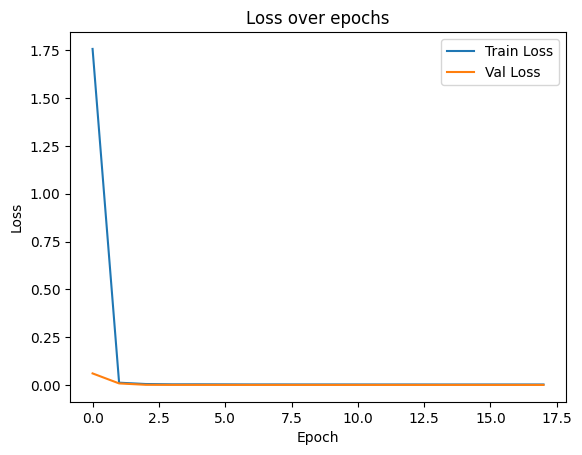

In [82]:
import matplotlib.pyplot as plt

plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Val Loss')
plt.title('Loss over epochs')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()


In [88]:
test_loss = final_model.evaluate(X_test, y_test, verbose=0)
print("Test MSE Loss:", test_loss)

y_pred = final_model.predict(X_test)
print("y_pred shape:", y_pred.shape)
print("y_pred :", y_pred[-204])


Test MSE Loss: [0.002896695164963603, 0.03780427202582359]
7/7 [==============================] - 0s 6ms/step
y_pred shape: (204, 1)
y_pred : [0.37550923]


In [ ]:
import matplotlib.pyplot as plt

# y_test: actual target values (shape: (num_samples,) or similar)
# y_pred: predicted values from your model (same shape as y_test)

# y_pred_original = scaler.inverse_transform(y_pred)
plt.figure(figsize=(10, 6))
plt.plot(y_test, label='Actual')
plt.plot(y_pred, label='Predicted')
plt.title('Comparison of Actual vs. Predicted')
plt.xlabel('Samples (Test Data Index)')
plt.ylabel('Target Value')
plt.legend()
plt.show()


ValueError: non-broadcastable output operand with shape (204,1) doesn't match the broadcast shape (204,10)